In [68]:
import os
import numpy as np
import pandas as pd
from matplotlib.image import imread
from tensorflow.keras.metrics import AUC as auc
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
data_dir = 'chest_xray'

In [70]:
os.listdir(data_dir)

['chest_xray', 'test', 'train', 'val', '__MACOSX']

In [71]:
test_path = data_dir + '/test'
train_path = data_dir + '/train'
val_path = data_dir + '/val'

In [72]:
os.listdir(test_path)

['NORMAL', 'PNEUMONIA']

In [73]:
os.listdir(train_path + '/pneumonia')[0]

'person1000_bacteria_2931.jpeg'

In [74]:
positive = train_path + '/pneumonia/' + 'person63_bacteria_306.jpeg'
pos_image = imread(positive)
pos_image.shape

(736, 1048)

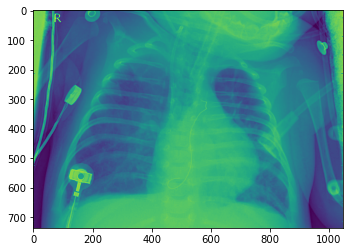

In [75]:
plt.imshow(pos_image)

In [76]:
len(os.listdir(train_path + '/pneumonia'))

3875

In [77]:
len(os.listdir(train_path + '/normal'))

1341

In [78]:
# We're going to have images of different dimensions, so handle that before using the CNN
dim1 = []
dim2 = []

for image_filename in os.listdir(test_path + '/normal'):
    img = imread(test_path + '/normal/' + image_filename)
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

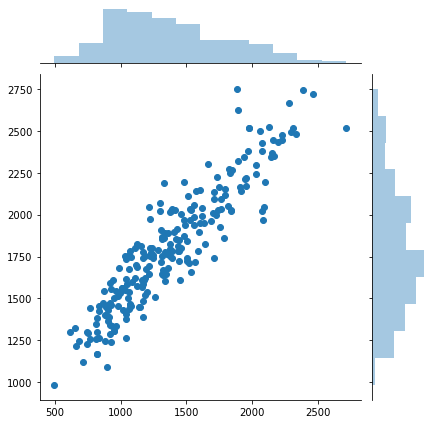

In [79]:
# Plot the image sizes
sns.jointplot(dim1, dim2)

In [80]:
# Going to get the mean image size and resize to that
np.mean(dim1)

1369.0897435897436

In [81]:
np.mean(dim2)

1800.3034188034187

In [82]:
image_shape = (300, 300, 3)

In [83]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [84]:
image_gen = ImageDataGenerator(horizontal_flip=True,
                               fill_mode='nearest')

In [85]:
image_gen.flow_from_directory(train_path)

Found 5216 images belonging to 2 classes.


In [86]:
image_gen.flow_from_directory(test_path)

Found 624 images belonging to 2 classes.


In [87]:
image_gen.flow_from_directory(val_path)

Found 16 images belonging to 2 classes.


<h2>Building a Model</h2>

In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.metrics import Accuracy, AUC

In [89]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=image_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2,2)))

# model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2,2)))

# model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',
             metrics=[AUC()])

In [90]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 78400)            

<h2>Regularization</h2>

In [91]:
from tensorflow.keras.callbacks import EarlyStopping

In [92]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)
batch_size = 64

In [93]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size = image_shape[:2],
                                               batch_size = batch_size,
                                               class_mode = 'binary')

Found 5216 images belonging to 2 classes.


In [94]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               batch_size = batch_size,
                                               class_mode='binary',
                                               shuffle=False) # Don't want to shuffle test data and lose labels

Found 624 images belonging to 2 classes.


In [95]:
test_image_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

<h3>Running the Model</h3>

In [ ]:
# Running without early stop for now - not enough examples for 'val_loss'?
results = model.fit(train_image_gen, epochs=20,
                             validation_data=test_image_gen,
                    callbacks=[early_stop]
                   )

Train for 82 steps, validate for 10 steps
Epoch 1/20
23/82 [=======>......................] - ETA: 5:10 - loss: 241.9319 - auc_1: 0.5539

In [ ]:
metrics = pd.DataFrame(model.history.history)

In [ ]:
metrics[['accuracy', 'val_accuracy']].plot()

In [ ]:
metrics[['auc', 'val_auc']].plot()

In [ ]:
metrics[['loss', 'val_loss']].plot()

<p>We see that the model is overfitting significantly.</p>

In [ ]:
model.save('image_classifier_accuracy.h5')